In [1]:
# Modules will be reloaded every time a cell is executed
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier


from funmirtar.models.seeds import SEED_TYPE_TO_EXTRACTION_FUNCTION
from funmirtar.models.constants import SEEDS_TO_COUNT, SEED_COUNT_COLUMNS
from funmirtar.utils.plots import plot_feature_importance, plot_prc_with_seeds


In [3]:
FOLDER_PATH = "../data/preprocessed_for_ml/"
TRAIN_INPUT_FEATURES_PATH = Path(
    FOLDER_PATH + '3utr.sequences.refseq_id.mirna_fc.seed_cls.sequence.signal.conservation.seed_cls.ts_preds.train.pkl'
)
TEST_INPUT_FEATURES_PATH = Path(
    FOLDER_PATH + '3utr.sequences.refseq_id.mirna_fc.seed_cls.sequence.signal.conservation.seed_cls.ts_preds.test.pkl'
)

TRAIN_INPUT_FEATURES_PATH, TEST_INPUT_FEATURES_PATH

(PosixPath('../data/preprocessed_for_ml/3utr.sequences.refseq_id.mirna_fc.seed_cls.sequence.signal.conservation.seed_cls.ts_preds.train.pkl'),
 PosixPath('../data/preprocessed_for_ml/3utr.sequences.refseq_id.mirna_fc.seed_cls.sequence.signal.conservation.seed_cls.ts_preds.test.pkl'))

In [4]:
utils.check_random_state(3)
np.random.seed(1)

In [5]:
COLUMNS_FOR_PRED = [
    'transcript_length',
    'signal_binding_sites_count', 'signal_max', 'mean', 'std',
    'median', 'iqr', 'peak_count', 'mean_crossings'
]
COLUMNS_FOR_PRED.extend(SEEDS_TO_COUNT)
COLUMNS_FOR_PRED.extend(SEED_COUNT_COLUMNS)
# COLUMNS_FOR_PRED.remove('kmer6_bulge_or_mismatch_count')

In [6]:
data_train = pd.read_pickle(TRAIN_INPUT_FEATURES_PATH)
data_test = pd.read_pickle(TEST_INPUT_FEATURES_PATH)

In [7]:
data_train.rename(columns={'kmer6_mismatch_count':'kmer6_bulge_or_mismatch_count'}, inplace=True)
data_test.rename(columns={'kmer6_mismatch_count':'kmer6_bulge_or_mismatch_count'}, inplace=True)

In [8]:
x_seeds_train = data_train[SEED_COUNT_COLUMNS]
y_train = data_train.label

x_seeds_test = data_test[SEED_COUNT_COLUMNS]
y_test = data_test.label

In [9]:
x_seeds_signal_train = data_train[COLUMNS_FOR_PRED].fillna(0,inplace=False)
x_seeds_signal_test = data_test[COLUMNS_FOR_PRED].fillna(0,inplace=False)

### Train seed-based-only models

#### Logistic regression

In [10]:
model = LogisticRegression(max_iter=1000)
model.fit(x_seeds_train, y_train)

y_pred_seeds_lr_train = model.predict_proba(x_seeds_train)
y_pred_seeds_lr_test = model.predict_proba(x_seeds_test)

data_train['logistic_regression.seeds']=y_pred_seeds_lr_train[:,1]
data_test['logistic_regression.seeds']=y_pred_seeds_lr_test[:,1]

#### (Histogram) Gradient Boosting Classifier

In [11]:
model_seeds_tree = GradientBoostingClassifier()
model_seeds_tree.fit(x_seeds_train, y_train)

y_pred_seeds_tree_train = model_seeds_tree.predict_proba(x_seeds_train)
y_pred_seeds_tree_test = model_seeds_tree.predict_proba(x_seeds_test)

data_train['GradientBoostingClassifier.seeds'] = y_pred_seeds_tree_train[:,1]
data_test['GradientBoostingClassifier.seeds'] = y_pred_seeds_tree_test[:,1]

### Train seed and signal based models

#### Logistic regression

In [12]:
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(x_seeds_signal_train, y_train)

y_pred_seeds_signal_lr_train = model_lr.predict_proba(x_seeds_signal_train)
y_pred_seeds_signal_lr_test = model_lr.predict_proba(x_seeds_signal_test)

data_train['logistic_regression.seeds.signal']=y_pred_seeds_signal_lr_train[:,1]
data_test['logistic_regression.seeds.signal']=y_pred_seeds_signal_lr_test[:,1]

#### (Histogram) Gradient Boosting Classifier

In [13]:
model_tree = GradientBoostingClassifier()
model_tree.fit(x_seeds_signal_train, y_train)

y_pred_seeds_signal_tree_train = model_tree.predict_proba(x_seeds_signal_train)
y_pred_seeds_signal_tree_test = model_tree.predict_proba(x_seeds_signal_test)

data_train['GradientBoostingClassifier.seeds.signal'] = y_pred_seeds_signal_tree_train[:,1]
data_test['GradientBoostingClassifier.seeds.signal'] = y_pred_seeds_signal_tree_test[:,1]

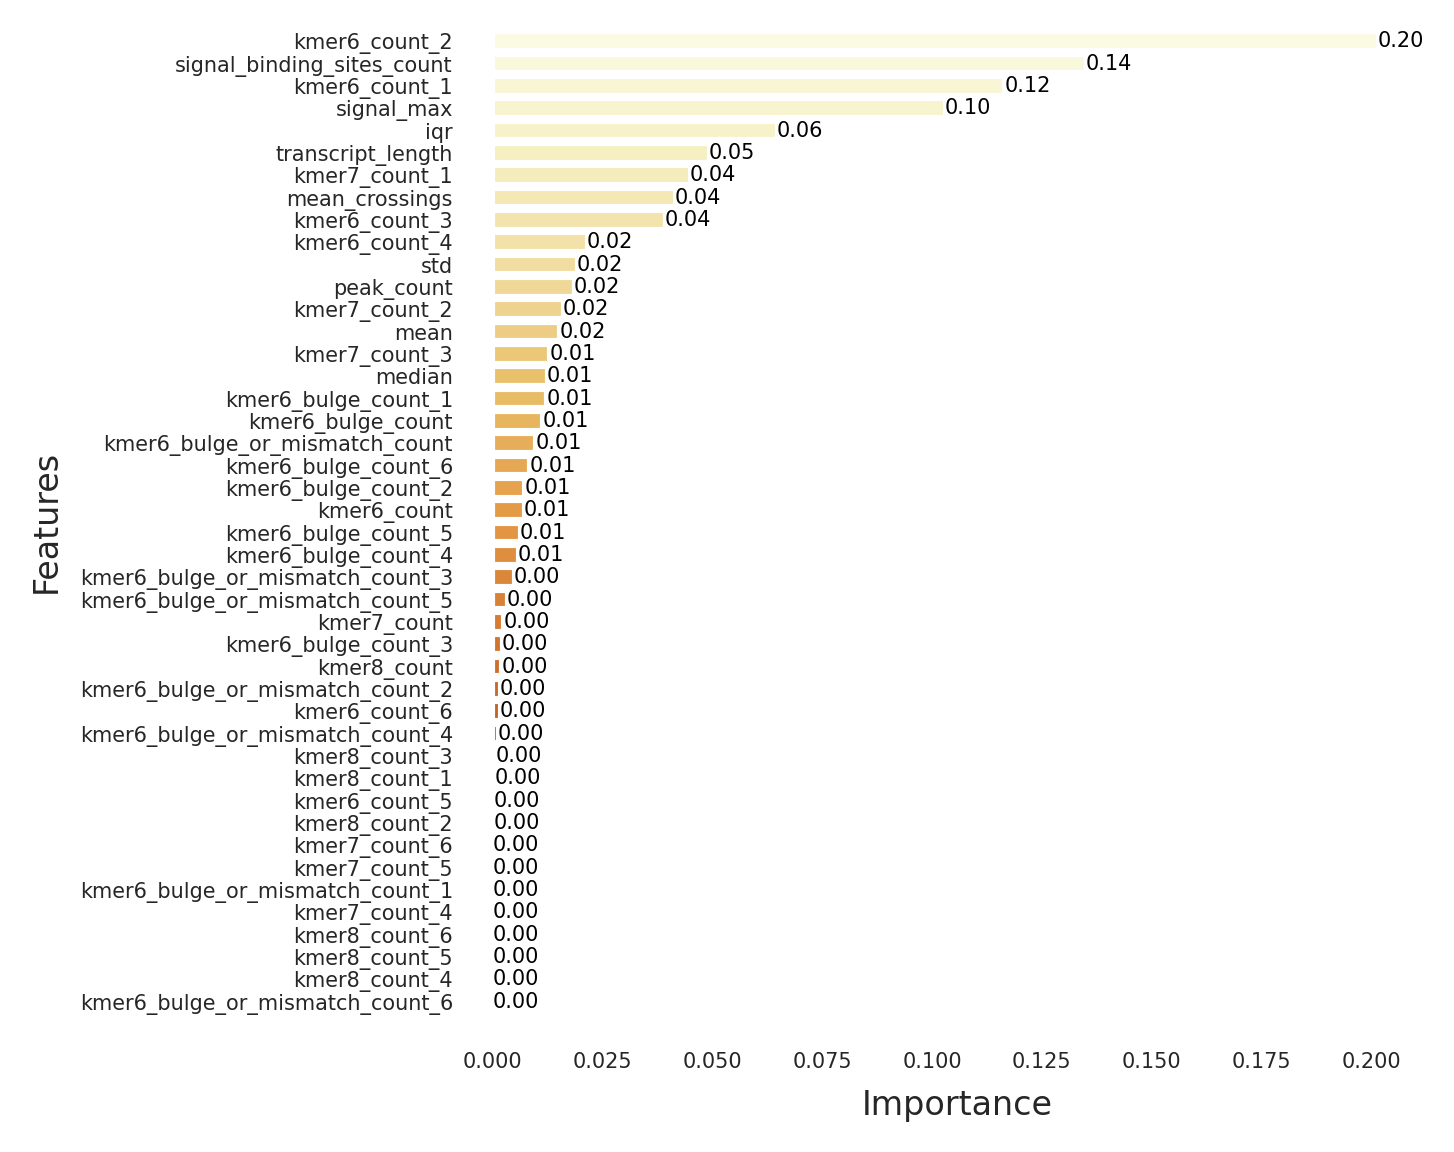

In [14]:
feature_importances = model_tree.feature_importances_
feature_names = x_seeds_signal_train.columns

plot_feature_importance(feature_names, feature_importances)

In [15]:
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb

# Train an XGBOOST classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_classifier.fit(x_seeds_signal_train, y_train)

# Make predictions with XGBOOST
xgb_y_pred_class = xgb_classifier.predict(x_seeds_signal_test)
xgb_y_pred = xgb_classifier.predict_proba(x_seeds_signal_test)

# Evaluate the XGBOOST classifier
xgb_accuracy = accuracy_score(y_test, xgb_y_pred_class)
xgb_report = classification_report(y_test, xgb_y_pred_class)

print(f'Accuracy (XGBoost): {xgb_accuracy}')
print('Classification Report (XGBoost):')
print(xgb_report)

data_test['xgb.seeds.signal'] = xgb_y_pred[:,1]
# data_train['xgb.seeds.signal']

Accuracy (XGBoost): 0.6625906441063557
Classification Report (XGBoost):
              precision    recall  f1-score   support

         0.0       0.69      0.90      0.78      9311
         1.0       0.50      0.19      0.28      4755

    accuracy                           0.66     14066
   macro avg       0.59      0.55      0.53     14066
weighted avg       0.62      0.66      0.61     14066



In [16]:
from sklearn.ensemble import RandomForestClassifier

# Train a RANDOM FOREST classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(x_seeds_signal_train, y_train)

# Make predictions
rf_y_pred_class = rf_classifier.predict(x_seeds_signal_test)
rf_y_pred = rf_classifier.predict_proba(x_seeds_signal_test)

# Evaluate the classifier
rf_accuracy = accuracy_score(y_test, rf_y_pred_class)
rf_report = classification_report(y_test, rf_y_pred_class)

print(f'Accuracy (Random Forest): {rf_accuracy}')
print('Classification Report (Random Forest):')
print(rf_report)

data_test['random_forest.seeds.signal'] = rf_y_pred[:,1]
# data_train['random_forest.seeds.signal']

Accuracy (Random Forest): 0.6638703256078488
Classification Report (Random Forest):
              precision    recall  f1-score   support

         0.0       0.68      0.92      0.78      9311
         1.0       0.51      0.16      0.25      4755

    accuracy                           0.66     14066
   macro avg       0.60      0.54      0.52     14066
weighted avg       0.62      0.66      0.60     14066



In [17]:
from sklearn.svm import SVC

svm_preds = {}
# for kernel in ['linear', 'poly', 'sigmoid', 'rbf']:
for kernel in ['rbf']:
    # Train a SVM classifier
    svm_classifier = SVC(kernel=kernel, random_state=42, probability=True, verbose=False, max_iter=5000) # class_weight = 'balanced'
    svm_classifier.fit(x_seeds_signal_train, y_train)

    # Make predictions with SVM
    svm_y_pred_class = svm_classifier.predict(x_seeds_signal_test)
    svm_y_pred = svm_classifier.predict_proba(x_seeds_signal_test)
    svm_preds[kernel] = svm_y_pred

    # Evaluate the SVM classifier
    svm_accuracy = accuracy_score(y_test, svm_y_pred_class)
    svm_report = classification_report(y_test, svm_y_pred_class)

    print(kernel)
    print(f'Accuracy (SVM): {svm_accuracy}')
    print('Classification Report (SVM):')
    print(svm_report)
    

data_test['svm.seeds.signal'] = svm_preds['rbf'][:,1]
# data_train['svm.seeds.signal']

/opt/conda/envs/mirna/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


rbf
Accuracy (SVM): 0.40260201905303566
Classification Report (SVM):
              precision    recall  f1-score   support

         0.0       0.65      0.22      0.32      9311
         1.0       0.33      0.77      0.47      4755

    accuracy                           0.40     14066
   macro avg       0.49      0.49      0.39     14066
weighted avg       0.54      0.40      0.37     14066



In [18]:
data_test['weighted context++ score percentile (filled NaNs)'] = data_test['weighted context++ score percentile'].fillna(0,inplace=False)
data_train['weighted context++ score percentile (filled NaNs)'] = data_train['weighted context++ score percentile'].fillna(0,inplace=False)

In [19]:
methods_to_plot=[
    'GradientBoostingClassifier.seeds', 
    'GradientBoostingClassifier.seeds.signal', 
    'weighted context++ score percentile (filled NaNs)',
    # 'logistic_regression.seeds',
    # 'logistic_regression.seeds.signal',
    # 'svm.seeds.signal',
    # 'random_forest.seeds.signal',
    # 'xgb.seeds.signal',
]

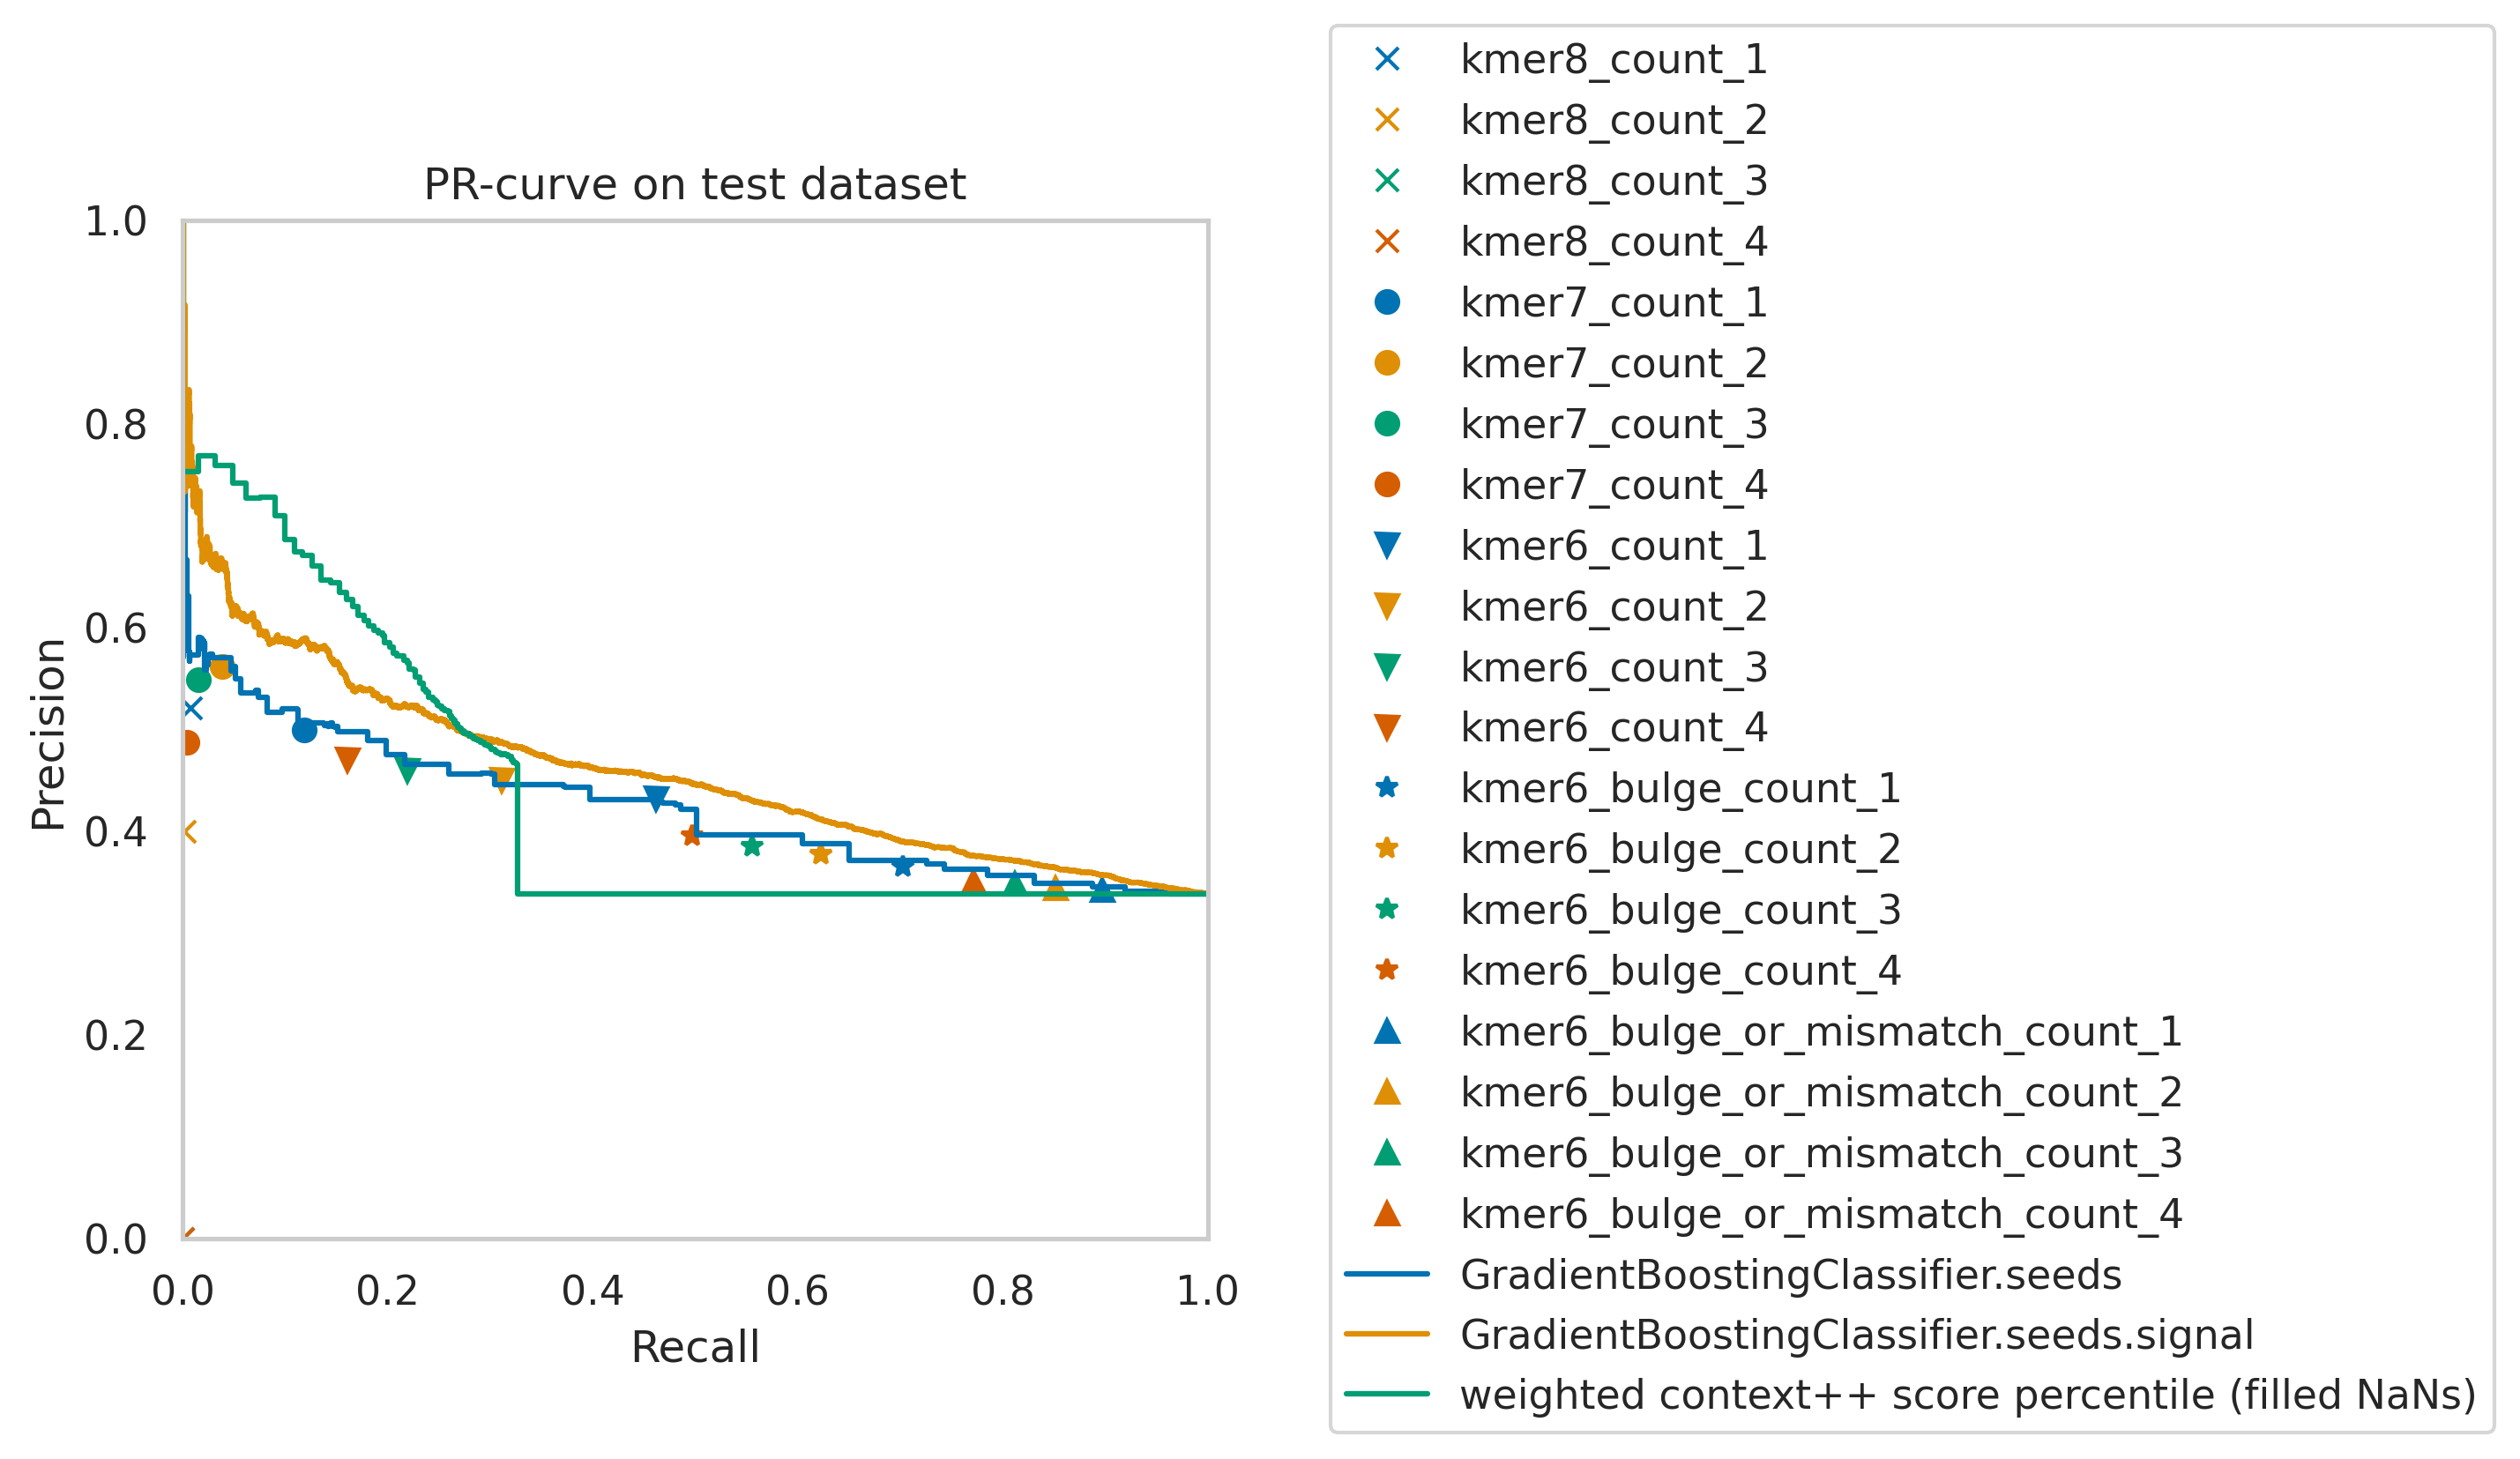

14066  total test samples


In [20]:
_, ax = plot_prc_with_seeds(
    data_test, 
    SEED_TYPE_TO_EXTRACTION_FUNCTION, 
    methods_to_plot,
    title='PR-curve on test dataset',
)
print(len(y_test), ' total test samples')

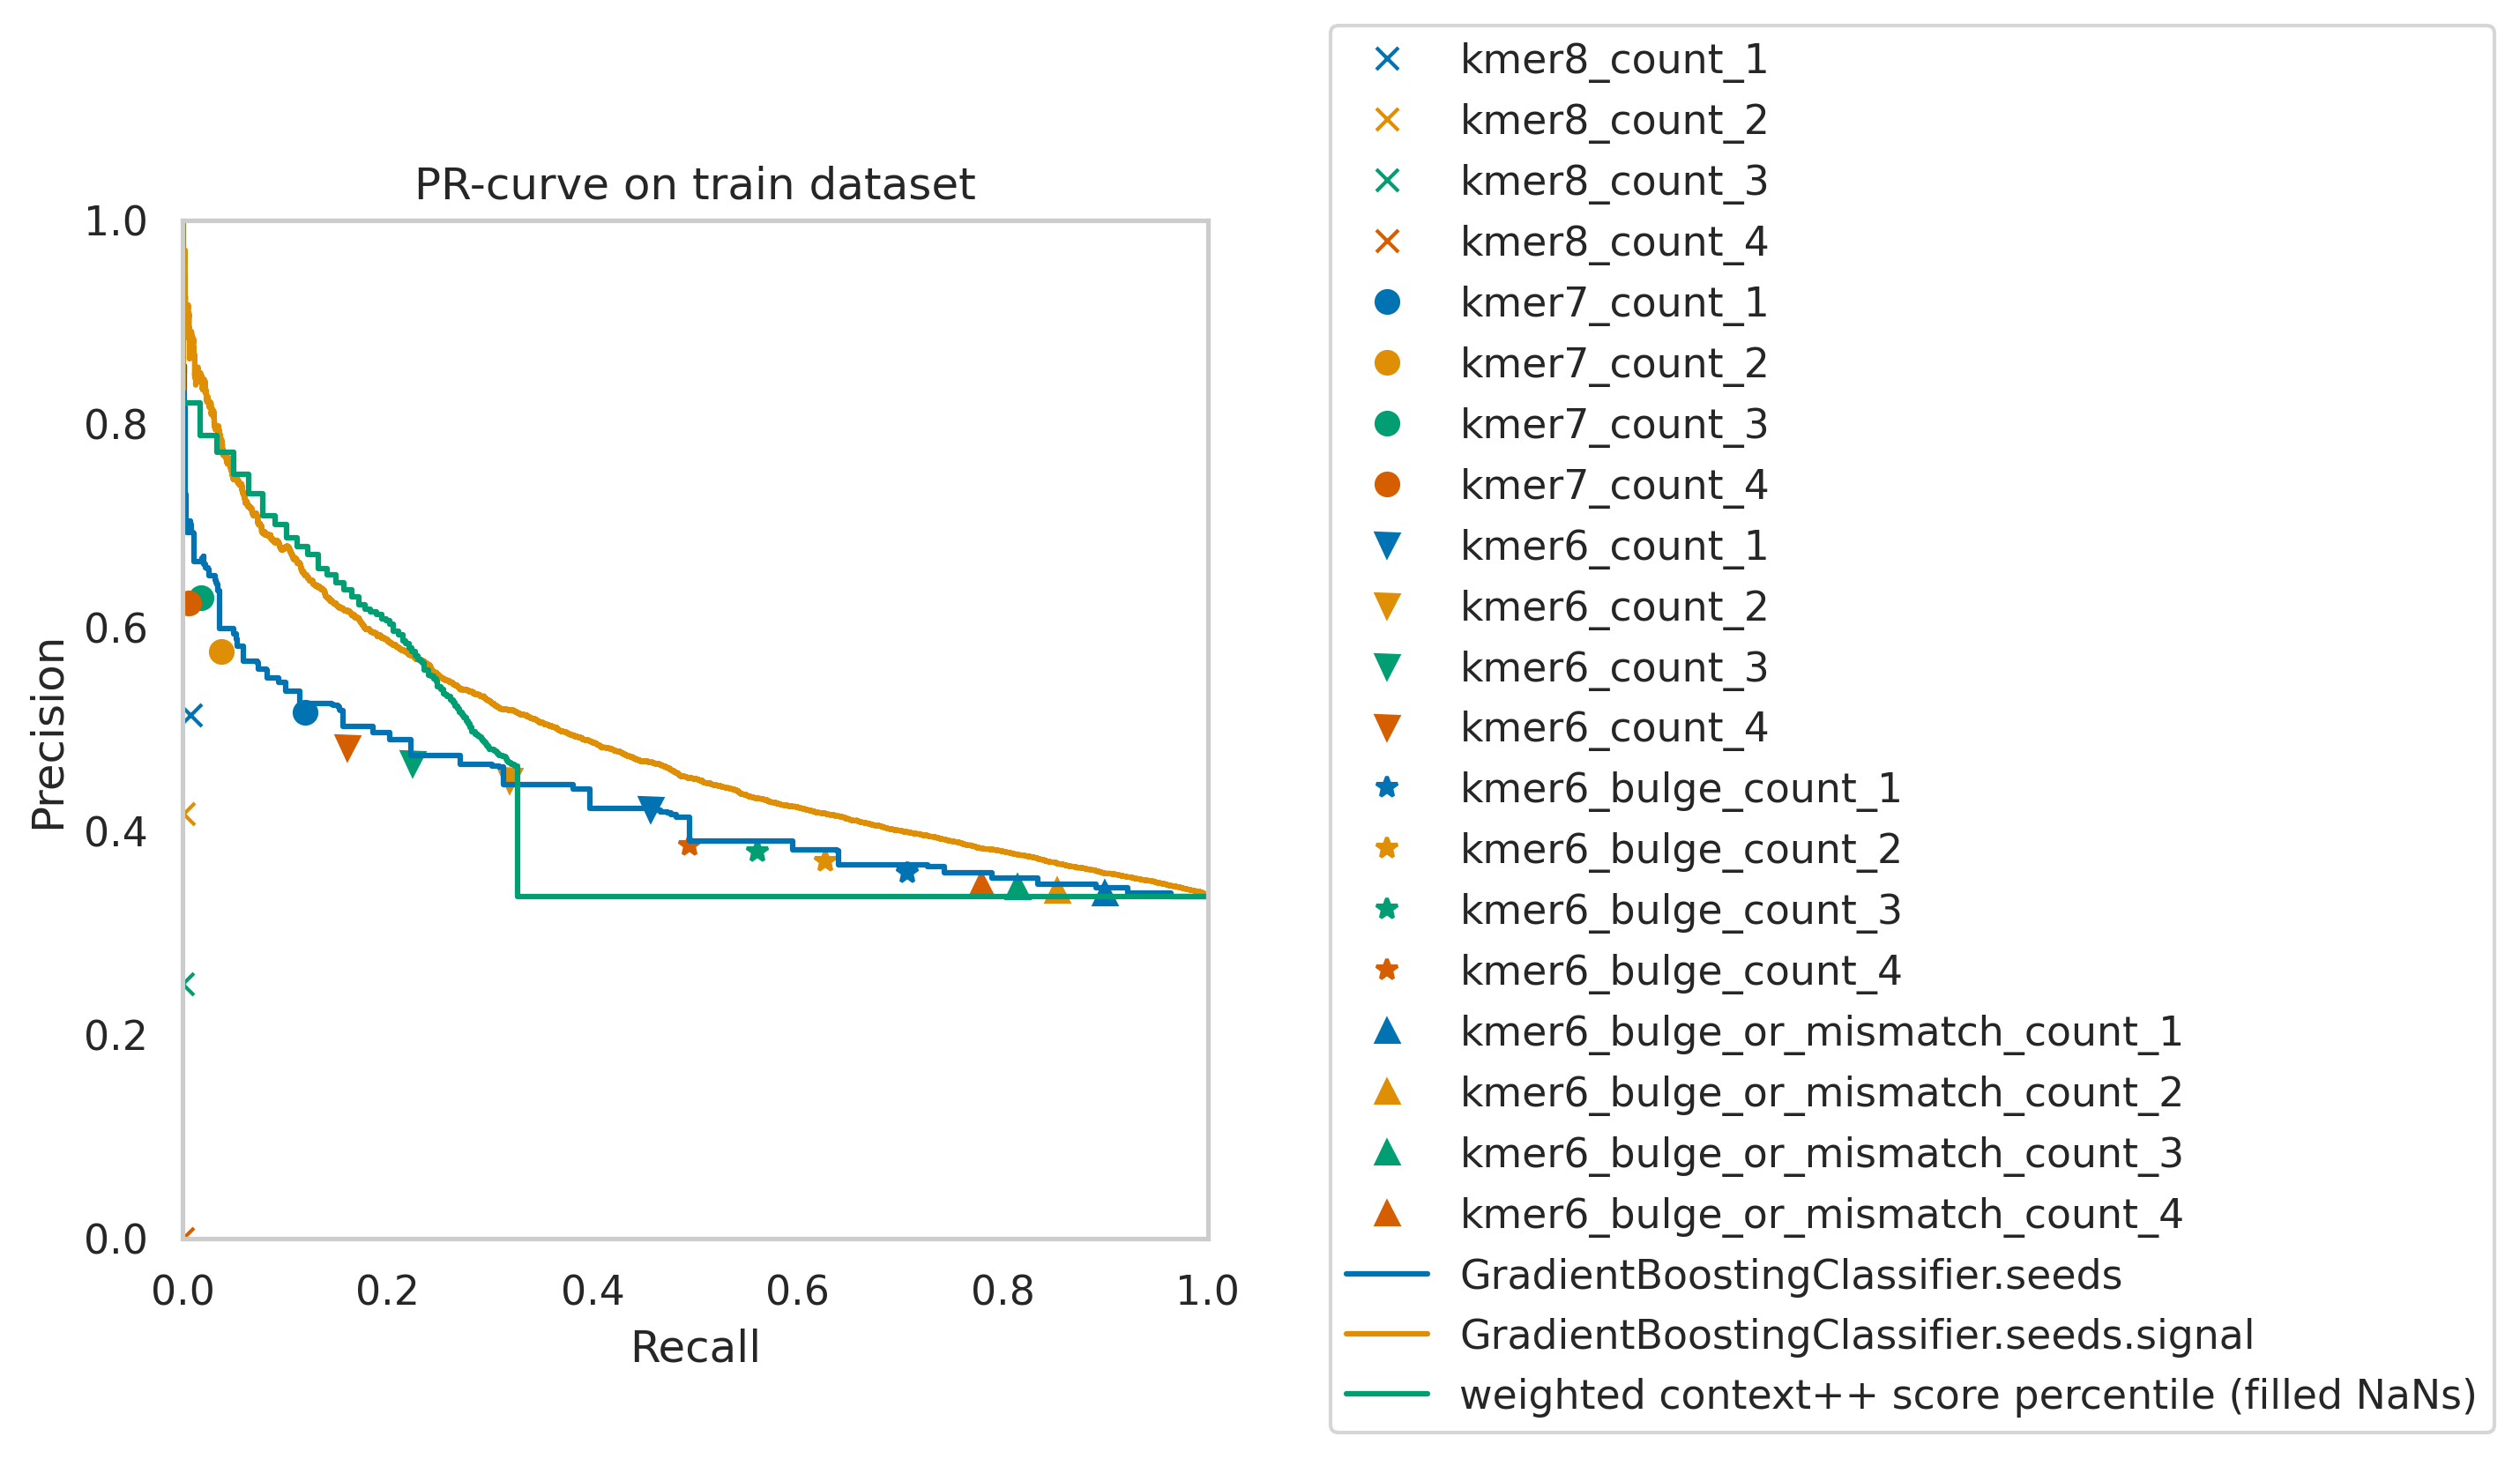

42148  total train samples


In [21]:
_, ax = plot_prc_with_seeds(
    data_train, 
    SEED_TYPE_TO_EXTRACTION_FUNCTION, 
    methods_to_plot,
    title='PR-curve on train dataset',
)
print(len(data_train.label), ' total train samples')